In [11]:
# import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
from alstm import ALSTMModel
from nltk.corpus import stopwords
from text_preprocessor import TextPreprocessor
from training import train_model, evaluate_model
from preprocess import collate_fn, read_dataset, log_model_train, plot_model_history, log_report_and_conf_mat,log_model_history, TextClassificationDataset
import os
import time

# Preprocess Data

In [12]:
# baca data
train_df = read_dataset('../dataset/trec_train.csv')
test_df = read_dataset('../dataset/trec_test.csv')

# drop ABBR (singkatan)
train_df = train_df[train_df['coarse_label'] != 0]
train_df['coarse_label'] = train_df['coarse_label'].apply(lambda x: x-1)
test_df = test_df[test_df['coarse_label'] != 0]
test_df['coarse_label'] = test_df['coarse_label'].apply(lambda x: x-1)

# ubah daftar label
label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]

train_texts = train_df['text'].values
test_texts = test_df['text'].values

train_labels = train_df['coarse_label'].values
test_labels = test_df['coarse_label'].values

In [13]:
# bagi data train menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

X_test = test_texts
y_test = test_labels

In [14]:
# stop = stop = set(stopwords.words('english'))
preprocessor = TextPreprocessor(max_vocab_size=10000, max_seq_length=50)

trec_vocab = preprocessor.get_vocab_from_texts([*X_test, *X_val, *X_train], use_stopwords=False)

# unduh pretrained embedding google-news-300
preprocessor.download_model(
    model_name='word2vec-google-news-300',
    filter_from_vocab=trec_vocab,
)

print(f'Jumlah vocabulary/kosa kata: {len(trec_vocab)}')

Jumlah vocabulary/kosa kata: 8896


## Tokenisasi dan pembersihan data

In [15]:
X_train_seq = preprocessor.transform(X_train, use_stopwords=False)
X_val_seq = preprocessor.transform(X_val, use_stopwords=False)
X_test_seq = preprocessor.transform(X_test, use_stopwords=False)

# Persiapan dataset dan dataloader pytorch

In [16]:
total_labels = len(label_names)

# buat dataset
cross_dataset = TextClassificationDataset(preprocessor.transform(train_texts, use_stopwords=False), train_labels)
train_dataset = TextClassificationDataset(X_train_seq, y_train)
val_dataset = TextClassificationDataset(X_val_seq, y_val)
test_dataset = TextClassificationDataset(X_test_seq, y_test)

In [17]:
batch_size=50
num_workers=0

torch.manual_seed(42)

# buat dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    collate_fn=collate_fn)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate_fn)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate_fn)

# persiapkan device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

grid_search = {
    'dropout': [0.0, 0.2, 0.4, 0.6, 0.8],
    'n_heads': [1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75, 150]
}

cfg = {
    'output': len(set(train_labels)),
    'bidirectional': True,
    'vocab_size': preprocessor.vocab_size,
    'context_length': 100,
    'emb_dim': 300,
    'hidden_size': 150,
    'qkv_bias': False,
    'device': device,
    'lstm_layers': 1,
}

Memulai training model_001_0.0
Test Loss: 0.4741, Test Acc: 0.9084

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.90      0.73      0.81        94
        DESC       0.87      0.95      0.91       138
         HUM       0.89      0.95      0.92        65
         LOC       0.96      0.93      0.94        81
         NUM       0.95      0.96      0.96       113

    accuracy                           0.91       491
   macro avg       0.91      0.91      0.91       491
weighted avg       0.91      0.91      0.91       491


Confusion Matrix:
[[ 69  12   8   2   3]
 [  5 131   0   0   2]
 [  2   0  62   1   0]
 [  1   4   0  75   1]
 [  0   4   0   0 109]]
Test Loss: 0.3163, Test Acc: 0.8982

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.80      0.80      0.80        94
        DESC       0.94      0.91      0.92       138
         HUM       0.95      0.89      0.92        65
        

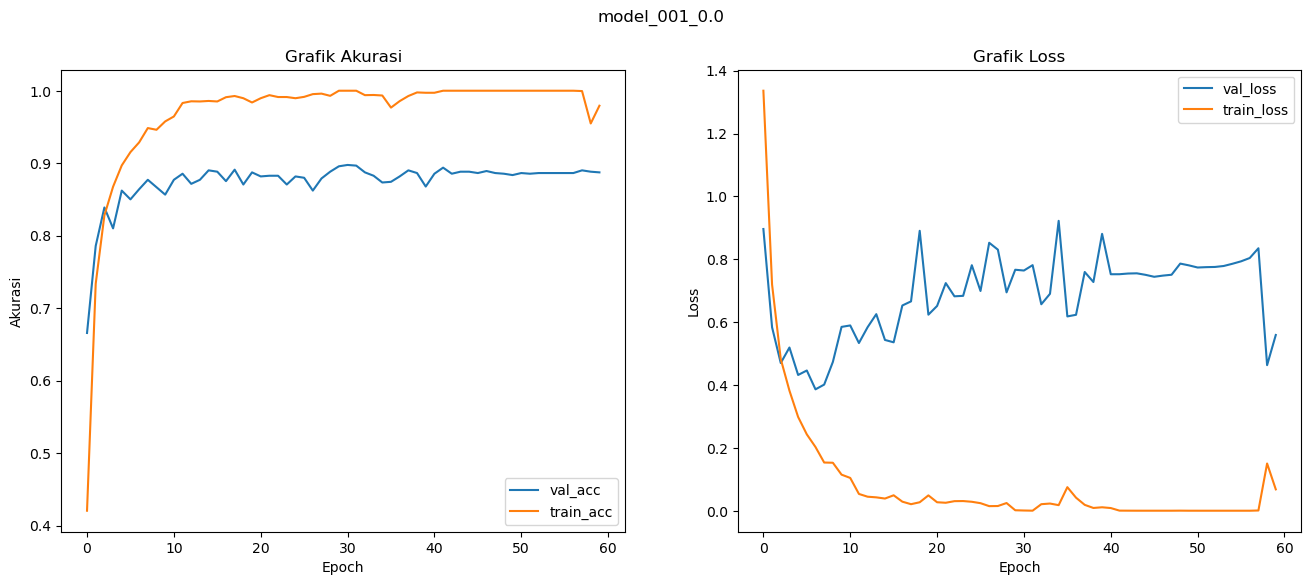

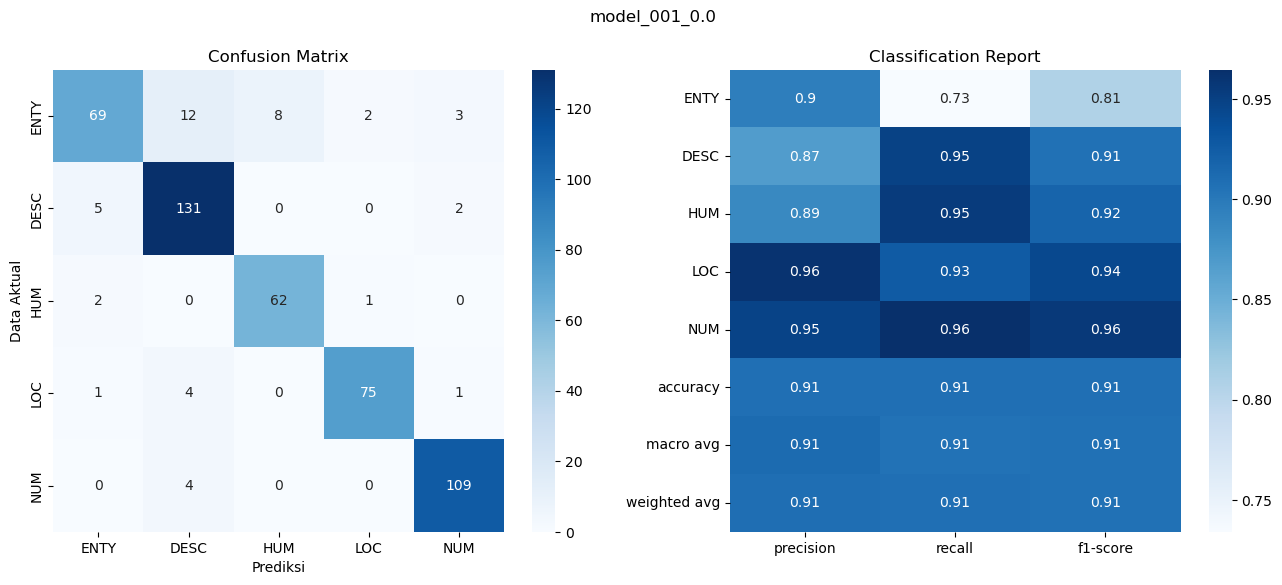

dict_values(['1', '0.0', '0.9793', '0.9083503054989817', '0.0681', '0.47414500466614296', '0.8981670061099797', '0.3163306384732427', '04:09', '1'])
model logged
model_001_0.0 selesai di-training. Total waktu: 04:09
Memulai training model_001_0.2
Test Loss: 0.3488, Test Acc: 0.9226

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.88      0.86      0.87        94
        DESC       0.89      0.96      0.93       138
         HUM       0.94      0.95      0.95        65
         LOC       0.94      0.93      0.93        81
         NUM       0.98      0.90      0.94       113

    accuracy                           0.92       491
   macro avg       0.93      0.92      0.92       491
weighted avg       0.92      0.92      0.92       491


Confusion Matrix:
[[ 81   7   4   1   1]
 [  5 133   0   0   0]
 [  1   0  62   2   0]
 [  2   3   0  75   1]
 [  3   6   0   2 102]]
Test Loss: 0.2987, Test Acc: 0.9002

Classification Report:
         

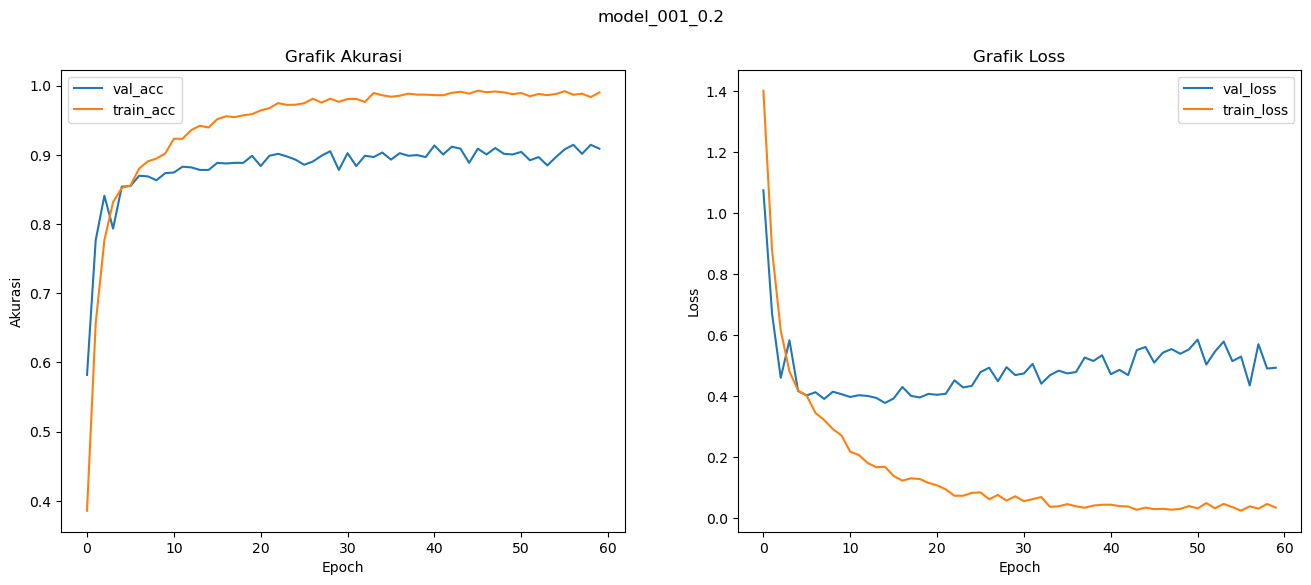

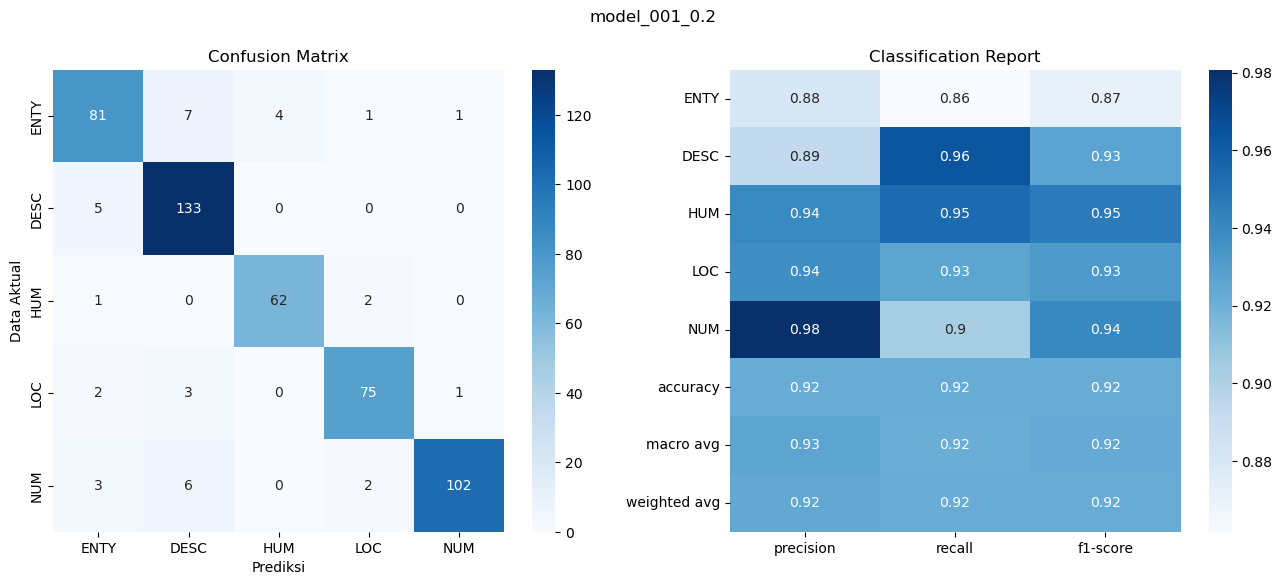

model logged
model_001_0.2 selesai di-training. Total waktu: 04:21
Memulai training model_001_0.4


KeyboardInterrupt: 

In [19]:
csv_path = 'alstm/alstm.csv'

for n_heads in grid_search['n_heads']:
    folder_path = f'alstm/alstm_{n_heads:03d}'
    # buat folder jika belum ada
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    for dropout in grid_search['dropout']:
        model_name = f'model_{n_heads:03d}_{dropout}'
        best_model_name = model_name + '_best_model'

        model_folder = f'{folder_path}/{model_name}'
        # buat folder model jika belum ada
        if not os.path.exists(model_folder):
            os.mkdir(model_folder)

        
        # update cfg
        cfg['drop_rate'] = dropout
        cfg['n_heads'] = n_heads
        
        model = ALSTMModel(cfg)
        model.to(device)

        # copy embedding google-news-300
        model.embedding.weight.data.copy_(torch.from_numpy(preprocessor.embedding_matrix))
        # freeze layer embedding
        model.embedding.weight.requires_grad = False
        
        # loss function dan optimizer
        learning_rate=0.001
        weight_decay=0.1
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        EPOCHS = 60
        start_train = time.time()

        print(f'Memulai training {model_name}')
        history = train_model(
            model=model,
            train_loader=train_loader,
            valid_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=EPOCHS,
            log=False,
            best_model_path=f'{model_folder}/{best_model_name}.pt'
        )

        end_train = time.time()
        total_train = (end_train - start_train)
        # ubah waktu menjadi format MM:SS
        minutes, seconds = divmod(int(total_train), 60)
        formatted_time = f"{minutes:02d}:{seconds:02d}"

        best_model = ALSTMModel(cfg)
        best_model.load_state_dict(torch.load(f'{model_folder}/{best_model_name}.pt', weights_only=True))
        torch.save(model.state_dict(), f'{model_folder}/{model_name}.pt')

        # evaluasi pada data test
        test_loss, test_acc, report, conf_mat = evaluate_model(
            model=model,
            test_loader=test_loader,
            criterion=criterion,
            device=device,
            label_names=label_names,
            return_report=True
        )

        best_model_test_loss, best_model_test_acc, best_model_report, best_model_conf_mat = evaluate_model(
            model=best_model,
            test_loader=test_loader,
            criterion=criterion,
            device=device,
            label_names=label_names,
            return_report=True
        )

        print(f"Akurasi pada data test : {test_acc:.4f}")
        print(f"Akurasi pada data test (best model): {best_model_test_acc:.4f}")

        # simpan log training dan testing
        plot_model_history(
            history=history,
            title=model_name,
            save_path=f'{model_folder}/train_test_graph.png'
        )

        log_model_history(
            history,
            save_path=f'{model_folder}/train_valid_log.csv'
        )

        log_report_and_conf_mat(
            title=model_name,
            report=report,
            confusion_matrix=conf_mat,
            label_names=label_names,
            save_path=f'{model_folder}/classification_report_and_confusion_matrix.png'
        )
        
        log_model_train(
            n_heads=n_heads,
            drop_rate=dropout,
            train_acc=f"{history['train_accs'][-1]:.4f}",
            test_acc=test_acc,
            train_loss=f"{history['train_losses'][-1]:.4f}",
            test_loss=test_loss,
            best_model_test_acc=best_model_test_acc,
            best_model_test_loss=best_model_test_loss,
            time=formatted_time,
            file=csv_path,
        )

        print(f'{model_name} selesai di-training. Total waktu: {formatted_time}')

        # hapus model dan optimizer untuk meringankan memori
        del model
        del optimizer